In [32]:
import torch
import pandas as pd
from sklearn import metrics
from scipy.io import loadmat
from os.path import exists
from tqdm import tqdm
from scipy.linalg import toeplitz
import time
import scipy
import os
import matplotlib.colors as mcolors 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
import cooler
import cooltools

sys.path.append("../")
import utils as ut
import plotting as plt2

In [33]:
dpath = "/scratch/indikar_root/indikar1/shared_data/population_pore_c/align_table/"

df = []
for f in os.listdir(dpath):
    if not 'parquet' in f:
        continue

    fpath = f"{dpath}{f}"
    tmp = pd.read_parquet(fpath)
    print(f, tmp.shape)
    df.append(tmp)

df = pd.concat(df)
print(f"{df.shape=}")
df.head()

batch04.GRCm39.align_table.parquet (8434829, 16)
batch02.GRCm39.align_table.parquet (907344, 16)
batch03.GRCm39.align_table.parquet (4579554, 16)
batch01.GRCm39.align_table.parquet (7508851, 16)
df.shape=(21430578, 16)


read_name  read_start  read_end  monomer_length  \
0  00000202-49cf-47b2-83bf-5eb3f6d98373           0       460             460   
1  00000202-49cf-47b2-83bf-5eb3f6d98373         460       687             227   
2  00000202-49cf-47b2-83bf-5eb3f6d98373         687       853             166   
3  00000202-49cf-47b2-83bf-5eb3f6d98373         853      1490             637   
4  00000202-49cf-47b2-83bf-5eb3f6d98373        1490      1714             224   

  chrom  ref_start     ref_end fragment_id  fragment_start  fragment_end  \
0    10   79553913  79554361.0   10:369876      79553685.0    79554367.0   
1    10   79553679  79553895.0   10:369876      79553685.0    79554367.0   
2    10   79553496  79553677.0   10:369875      79553502.0    79553685.0   
3    10   79552809  79553496.0   10:369874      79552815.0    79553502.0   
4  None         -1         NaN        None             NaN           NaN   

   is_duplicate  is_mapped  is_close  read_unique  read_group  mapping_quality  
0         False       True     False         True   1025705.0               60  
1         False       True      True         True   1025705.0               35  
2         False       True      True         True   1025705.0               26  
3         False       True      True         True   1025705.0               60  
4         False      False     False         True   1025705.0                0

In [34]:
def filter_and_prepare_data(df, resolution, mapq=60):
    """Filters and prepares contact data for analysis.

    Args:
        df (pd.DataFrame): The raw DataFrame containing contact data.
        resolution (int): The desired genomic resolution for binning.
        mapq (int, optional): The minimum mapping quality to filter by. Defaults to 60.

    Returns:
        pd.DataFrame: The filtered and processed DataFrame.
    """
    # Filtering
    filtered_df = df[df['mapping_quality'] >= mapq].copy()  # Filter by MAPQ
    filtered_df = filtered_df[filtered_df['fragment_id'].notna()] 

    # Binning
    filtered_df['bin'] = filtered_df['ref_start'].apply(lambda x: ut.bin_loci(x, resolution))
    return filtered_df  

resolution = 1000000
# resolution = 100000
# mapq = 60
mapq = 1
resolution_str = ut.human_readable_bp(resolution)  
print(f"Binning at {resolution_str} with mapq == {mapq}")
pdf = filter_and_prepare_data(df, resolution, mapq=mapq)
print(f"{pdf.shape=}")
pdf.head()

Binning at 1Mb with mapq == 1
pdf.shape=(14731046, 17)


read_name  read_start  read_end  monomer_length  \
0  00000202-49cf-47b2-83bf-5eb3f6d98373           0       460             460   
1  00000202-49cf-47b2-83bf-5eb3f6d98373         460       687             227   
2  00000202-49cf-47b2-83bf-5eb3f6d98373         687       853             166   
3  00000202-49cf-47b2-83bf-5eb3f6d98373         853      1490             637   
6  0000131a-4f27-4dc5-839d-09720b024db9           0       236             236   

  chrom  ref_start     ref_end fragment_id  fragment_start  fragment_end  \
0    10   79553913  79554361.0   10:369876      79553685.0    79554367.0   
1    10   79553679  79553895.0   10:369876      79553685.0    79554367.0   
2    10   79553496  79553677.0   10:369875      79553502.0    79553685.0   
3    10   79552809  79553496.0   10:369874      79552815.0    79553502.0   
6     4   45374671  45374875.0    4:195912      45374673.0    45374877.0   

   is_duplicate  is_mapped  is_close  read_unique  read_group  \
0         False       True     False         True   1025705.0   
1         False       True      True         True   1025705.0   
2         False       True      True         True   1025705.0   
3         False       True      True         True   1025705.0   
6         False       True     False         True    432517.0   

   mapping_quality   bin  
0               60  80.0  
1               35  80.0  
2               26  80.0  
3               60  80.0  
6               60  46.0

In [35]:
chrom = "1"
order_threshold = 2
sample_size = 1000

pdf = pdf[pdf['chrom'] == chrom]
print(f"{pdf.shape=}")

I, read_map = ut.process_chromosome_data(pdf, 
                                         order_threshold=order_threshold, 
                                         sample_size=sample_size)

print(f"{I.shape=}")
I.head()

pdf.shape=(993345, 17)
I.shape=(193, 1000)


read_code  4770   18882  7092   11589  37492  23590  22095  24426  30270  \
bin                                                                        
4.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8.0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

read_code  26014  ...  22769  30082  22192  30899  29631  13295  6738   38508  \
bin               ...                                                           
4.0          1.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
5.0          1.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8.0          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

read_code  7397   16748  
bin                      
4.0          0.0    0.0  
5.0          0.0    0.0  
6.0          0.0    0.0  
7.0          0.0    0.0  
8.0          0.0    0.0  

[5 rows x 1000 columns]

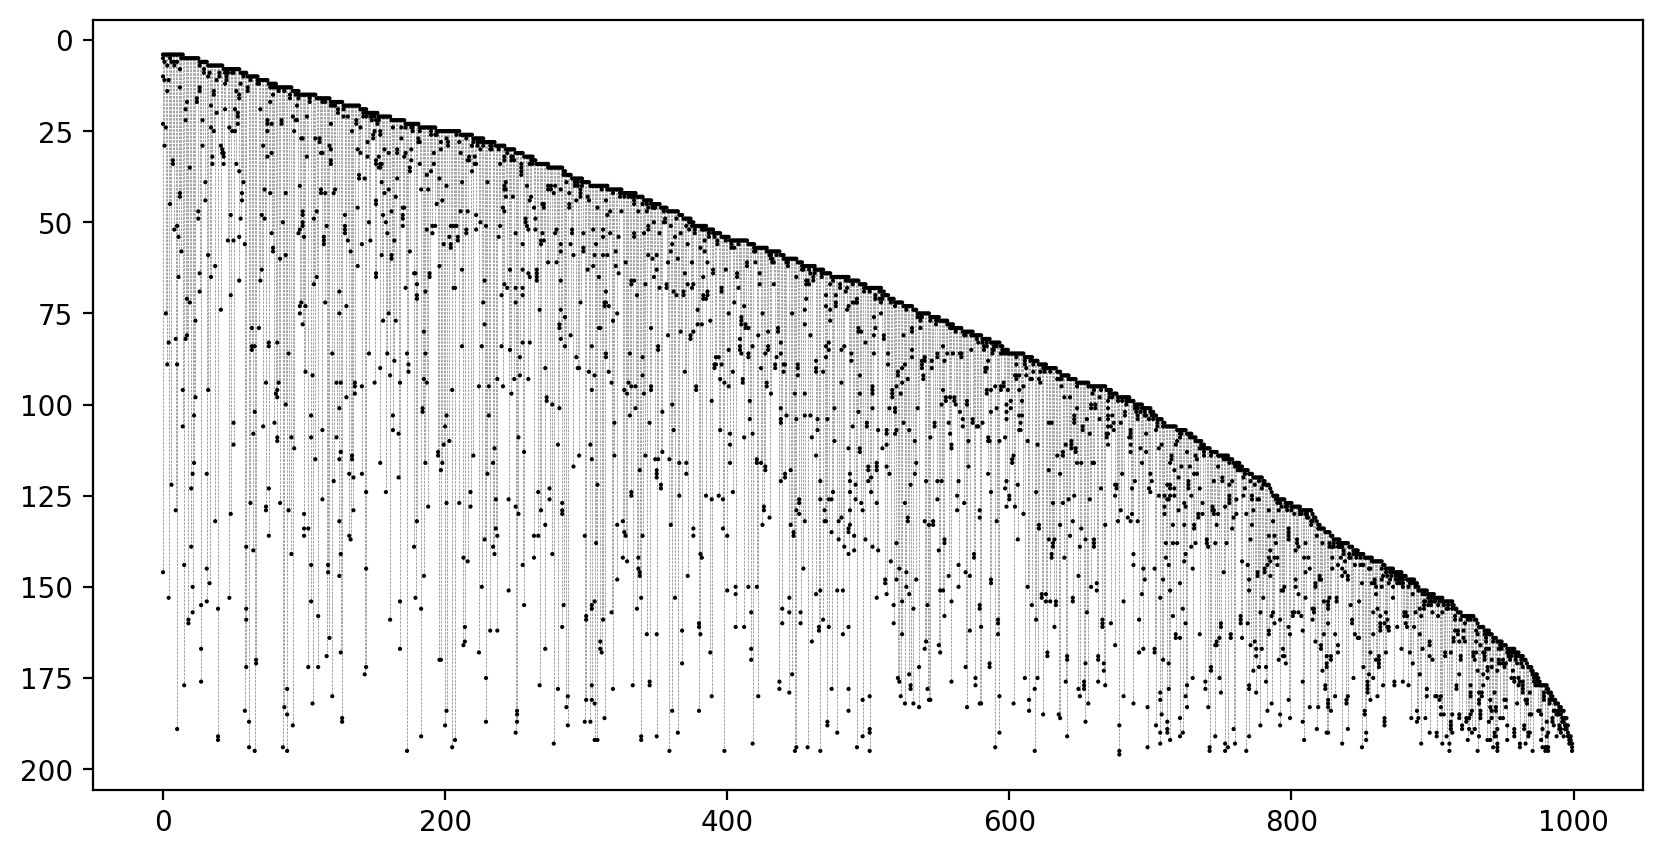

A.shape=(193, 193)


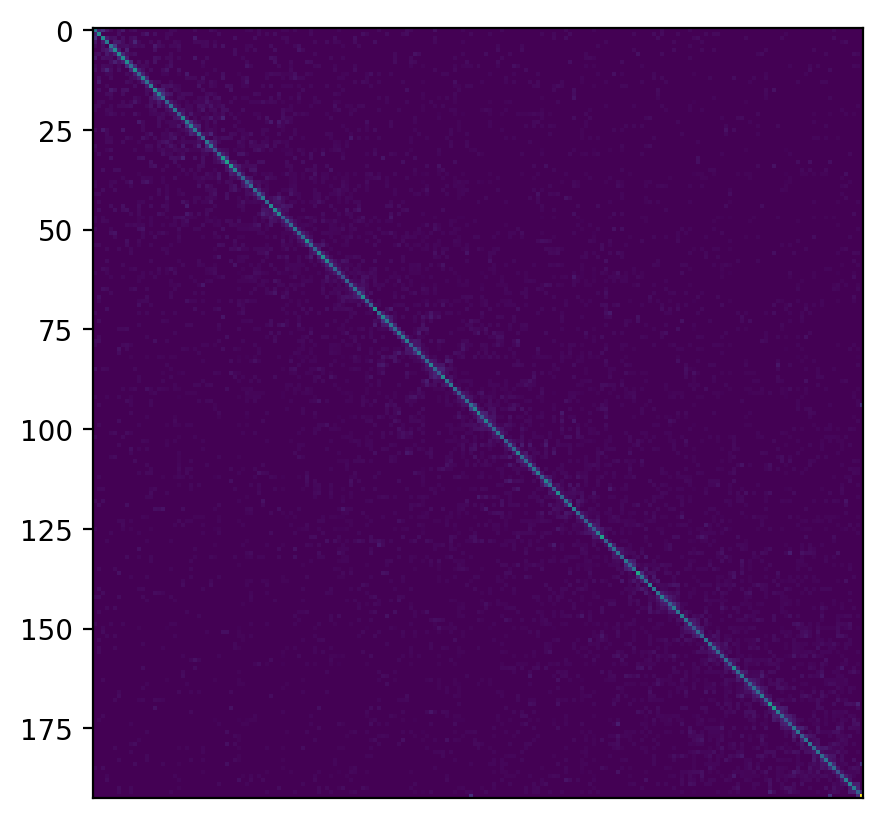

In [36]:
reload(plt2)
reload(ut)

node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 0.5,
    'zorder' : 2,
}

line_params = {
    'lw' : 0.25,
    'alpha' : 0.5,
    'zorder' : 1,
    'ls' : '--',
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 5
plt2.plot_incidence(ut.sort_by_lowest_index(I), 
               node_color='k',
               node_params=node_params,
               line_params=line_params)

plt.show()
A = ut.clique_expand_incidence(I, zero_diag=False)   
print(f"{A.shape=}")
plt.imshow(ut.normalize_kr(A).todense())
plt.xticks([])
plt.show()

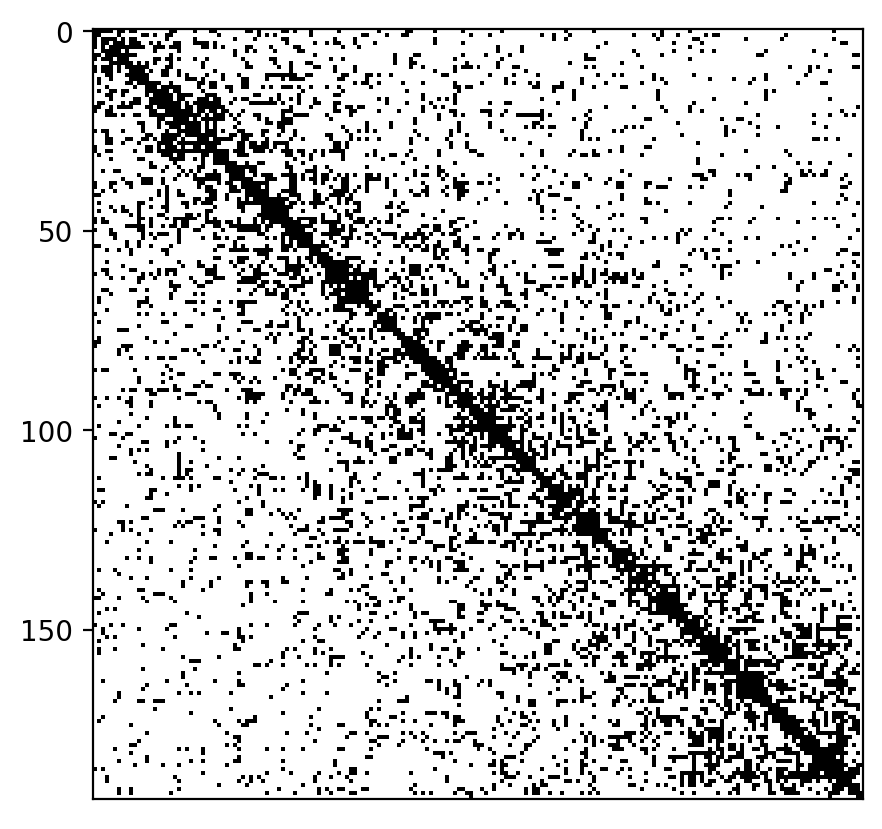

In [37]:
plt.spy(ut.normalize_kr(A).todense())
plt.xticks([])
plt.show()

Text(0.5, 0, 'Singular Value Index')

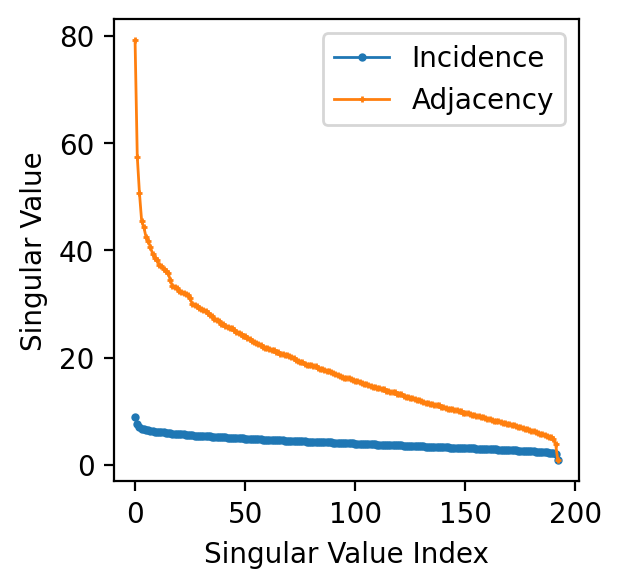

In [38]:
u_i, s_i, vh_i = np.linalg.svd(I)
u_a, s_a, vh_a = np.linalg.svd(A)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.plot(s_i, lw=1, marker="o", markersize=2, label='Incidence')
plt.plot(s_a, lw=1, marker="+", markersize=2, label='Adjacency')
plt.legend()

plt.ylabel('Singular Value')
plt.xlabel('Singular Value Index')

Text(0.5, 0, 'Singular Value Index')

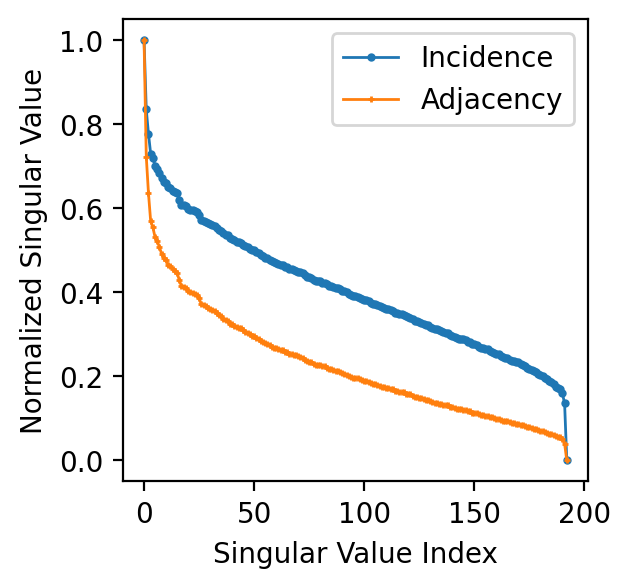

In [39]:
reload(ut)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
plt.plot(ut.normalize_1d_array(s_i), lw=1, marker="o", markersize=2, label='Incidence')
plt.plot(ut.normalize_1d_array(s_a), lw=1, marker="+", markersize=2, label='Adjacency')
plt.legend()

plt.ylabel('Normalized Singular Value')
plt.xlabel('Singular Value Index')

In [40]:
# break

# all chrom 1

In [41]:
reload(ut)
chrom = "1"
order_threshold = 1

pdf = pdf[pdf['chrom'] == chrom]
print(f"{pdf.shape=}")

I, read_map = ut.process_chromosome_data(pdf, 
                                         order_threshold=order_threshold, 
                                         sample_size=None)

Apc = ut.clique_expand_incidence(I, zero_diag=False)
print(f"{I.shape=} {Apc.shape=}")

pdf.shape=(993345, 18)
I.shape=(193, 122676) Apc.shape=(193, 193)


Text(0.5, 0, 'Order (Unique 1Mb Bins)')

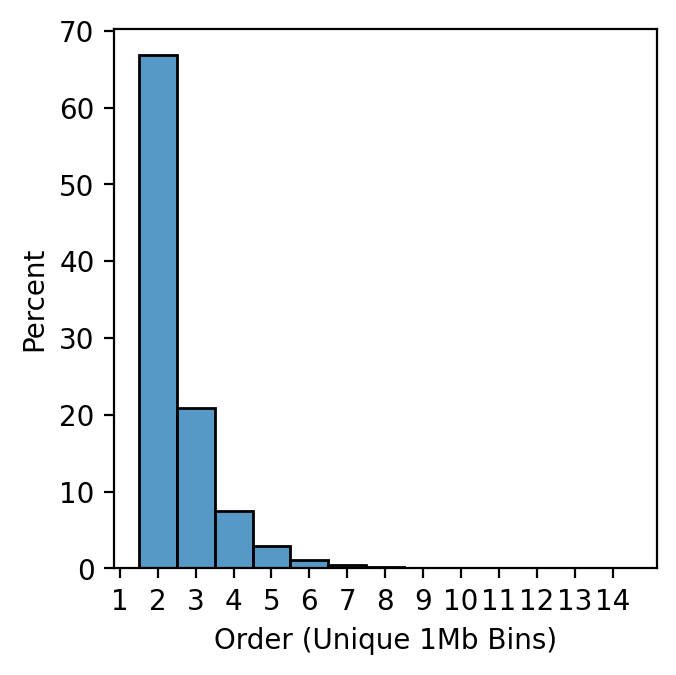

In [42]:
# plot the contact order of the population pore-c

degree = I.sum(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5
sns.histplot(x=degree, 
             discrete=True,
             stat='percent',
            )

plt.xticks(list(range(1, 15)))
plt.xlabel('Order (Unique 1Mb Bins)')


In [43]:
# break

# load the pop hi-c

In [44]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/f1219_population_hic/4DNFICF9PA9C.mcool"

chrom = "chr1"
clr = cooler.Cooler(f'{fpath}::resolutions/{resolution}')
Ahic = clr.matrix(balance=False).fetch(str(chrom))[:]
Ahic = np.nan_to_num(Ahic)
print(f"{Ahic.shape=}")

# drop the telomere
Ahic = Ahic[3:, :][:, 3:]
print(f"{Ahic.shape=}")

Ahic.shape=(196, 196)
Ahic.shape=(193, 193)


# drop problematic indices

In [45]:
reload(ut)

Apc = ut.remove_indices(Apc, [84, 85, 192])
Ahic = ut.remove_indices(Ahic, [84, 85, 192])

In [46]:
print(f"{Apc.shape=}")
print(f"{Apc.sum()=}")
print(f"{Apc.mean()=:.3f}")
print(f"{Apc.max()=}")

print()
print(f"{Ahic.shape=}")
print(f"{Ahic.sum()=}")
print(f"{Ahic.mean()=:.3f}")
print(f"{Ahic.max()=}")

Apc.shape=(190, 190)
Apc.sum()=882684.0
Apc.mean()=24.451
Apc.max()=2894.0

Ahic.shape=(190, 190)
Ahic.sum()=13851731
Ahic.mean()=383.704
Ahic.max()=137482


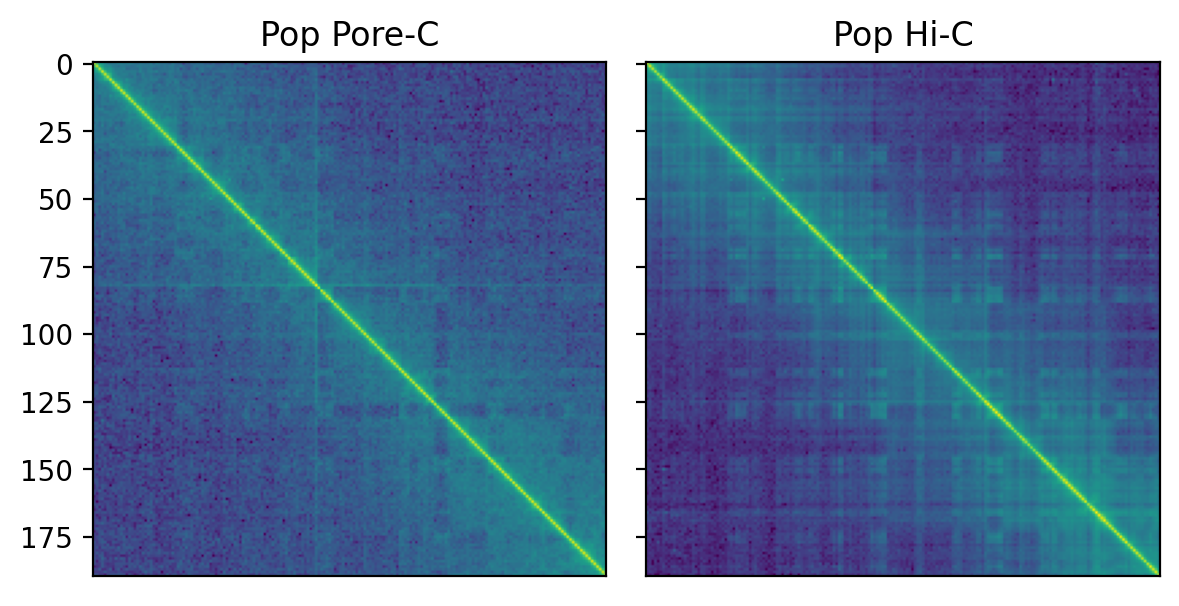

In [47]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(np.log1p(Apc))
axs[1].imshow(np.log1p(Ahic))

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

Apc_norm.shape=(190, 190)
Ahic_norm.shape=(190, 190)


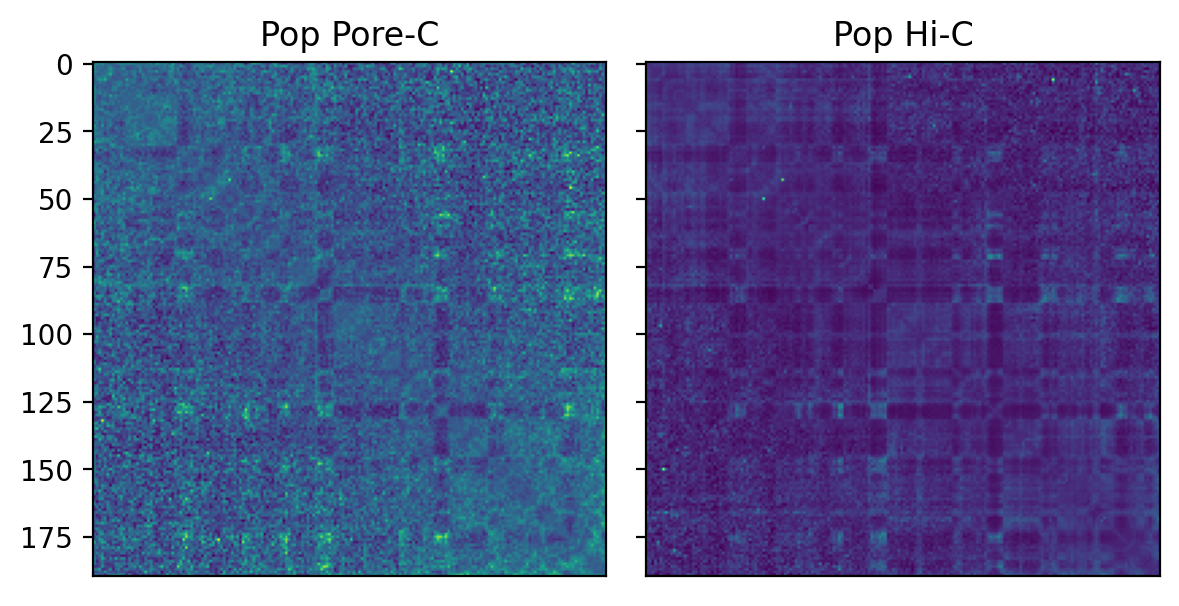

In [48]:
# normalized
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)

Apc_norm = ut.normalize_oe(ut.normalize_kr(Apc).todense())
Ahic_norm = ut.normalize_oe(ut.normalize_kr(Ahic).todense())

print(f"{Apc_norm.shape=}")
print(f"{Ahic_norm.shape=}")

axs[0].imshow(Apc_norm)
axs[1].imshow(Ahic_norm)

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

(36100,) (36100,)


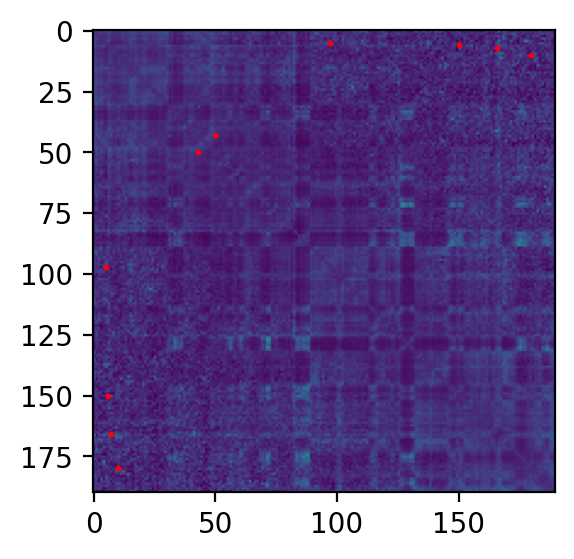

In [49]:
reload(ut)

top = 10
row_idx, col_idx = ut.get_sorted_upper_triangle_indices(Ahic_norm)
print(row_idx.shape, col_idx.shape)

plt.imshow(Ahic_norm)

for i in range(top):
    plt.scatter(row_idx[i], col_idx[i], s=1, c='r')

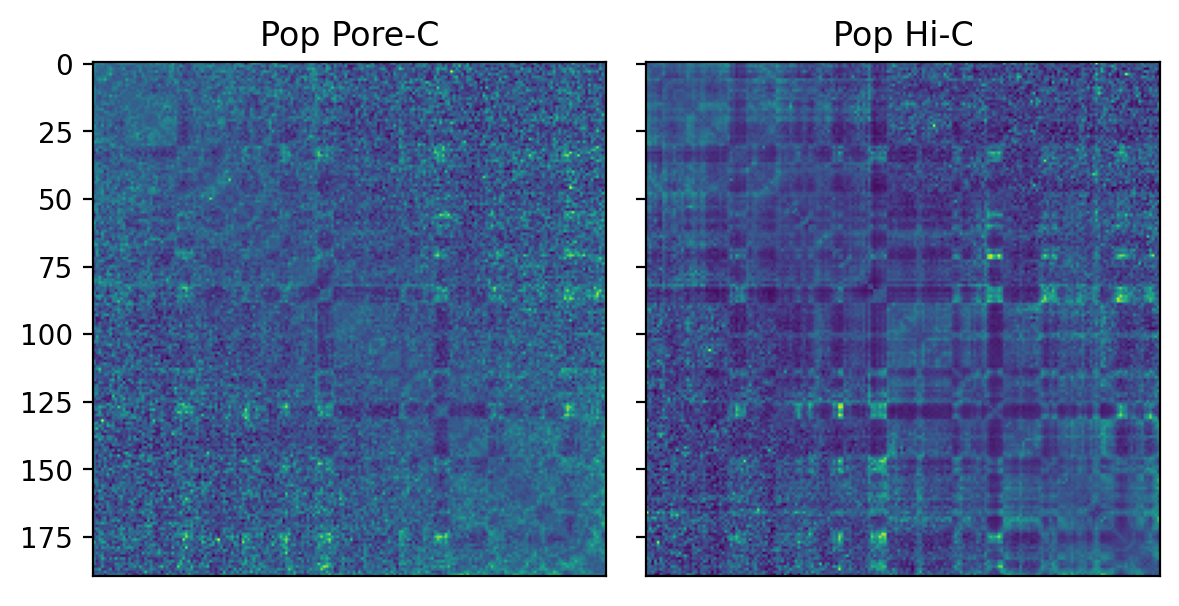

In [50]:
# update the matrix 
for i in range(top):
    Ahic_norm[row_idx[i], col_idx[i]] = Ahic_norm.mean()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].imshow(Apc_norm)
axs[1].imshow(Ahic_norm)

axs[0].set_title('Pop Pore-C')
axs[1].set_title('Pop Hi-C')

axs[0].set_xticks([])
axs[1].set_xticks([])
plt.tight_layout()

In [51]:
# break

([], [])

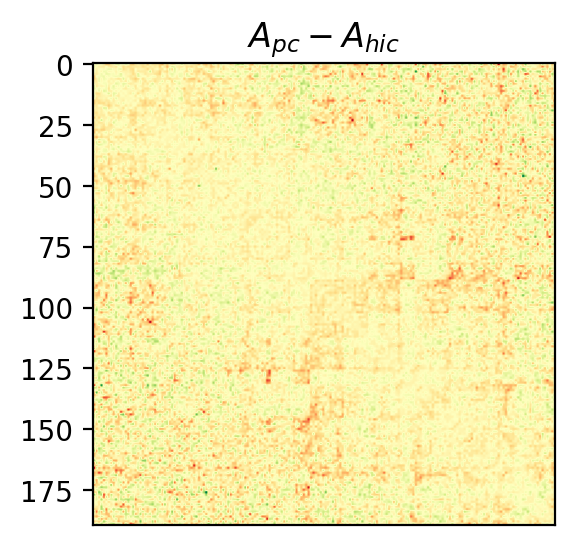

In [52]:
diff = Apc_norm - Ahic_norm
diff = diff - diff.mean()

plt.imshow(diff, cmap='RdYlGn')
plt.title(r"$A_{pc} - A_{hic}$")
plt.xticks([])

Text(0.5, 1.0, 'Local Differences')

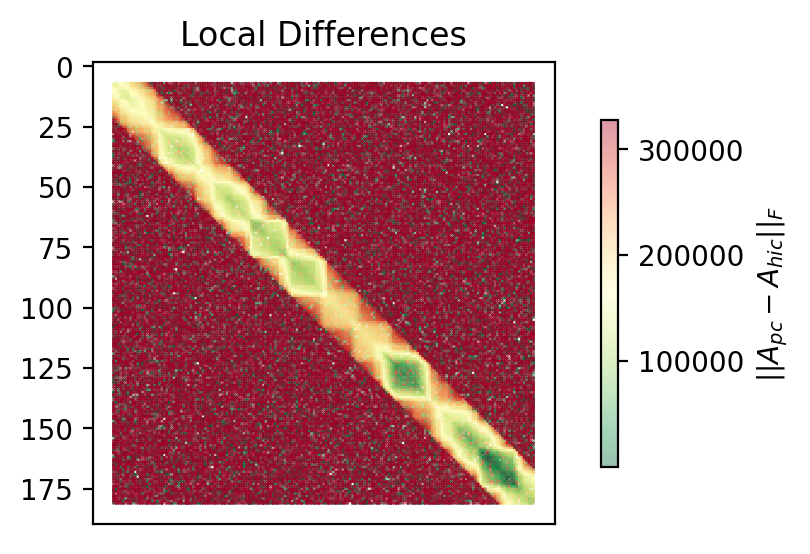

In [53]:

def f_norm_submatrix_diff(matrix1, matrix2, n, sample_size=1):
    """Calculates the F-norm of the difference between randomly sampled submatrices.

    Args:
        matrix1 (np.ndarray): The first symmetric matrix.
        matrix2 (np.ndarray): The second symmetric matrix.
        n (int): The size of the submatrices to sample.
        sample_size (int, optional): Number of submatrix samples to take. Defaults to 1.

    Returns:
        list: A list containing:
            * float: The average F-norm over the sampled submatrices.
            * tuple: The average centroid coordinates (row, column) across samples. 
    """

    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions.")
    if not (np.allclose(matrix1, matrix1.T) and np.allclose(matrix2, matrix2.T)):
        raise ValueError("Matrices must be symmetric.")

    f_norms = []
    centroids = []
    for _ in range(sample_size):
        # Randomly select top-left corner of submatrices
        row_idx = np.random.randint(0, matrix1.shape[0] - n)
        col_idx = np.random.randint(0, matrix2.shape[1] - n)

        submatrix1 = matrix1[row_idx:row_idx + n, col_idx:col_idx + n]
        submatrix2 = matrix2[row_idx:row_idx + n, col_idx:col_idx + n]

        diff = submatrix1 - submatrix2
        f_norms.append(np.linalg.norm(diff, ord='fro')) 

        # Calculate centroid (center of mass)
        centroid = (row_idx + n//2, col_idx + n//2) 
        centroids.append(centroid)

    return f_norms, centroids

sample_size = 100000
submat = 15
f_norms, centroids = f_norm_submatrix_diff(Apc, Ahic, n=submat, sample_size=sample_size)

x, y = zip(*centroids)
s = plt.scatter(x, y, c=f_norms, s=1, ec='none', cmap='RdYlGn_r', alpha=0.4)
plt.scatter(y, x, c=f_norms, s=1, ec='none', cmap='RdYlGn', alpha=0.4)
plt.colorbar(s, label=r"$||A_{pc} - A_{hic}||_{F}$", shrink=0.75) 
plt.gca().set_aspect('equal')
plt.xticks([])
plt.gca().invert_yaxis()
plt.title("Local Differences")

In [54]:
# break

r=0.668 p=0.00000


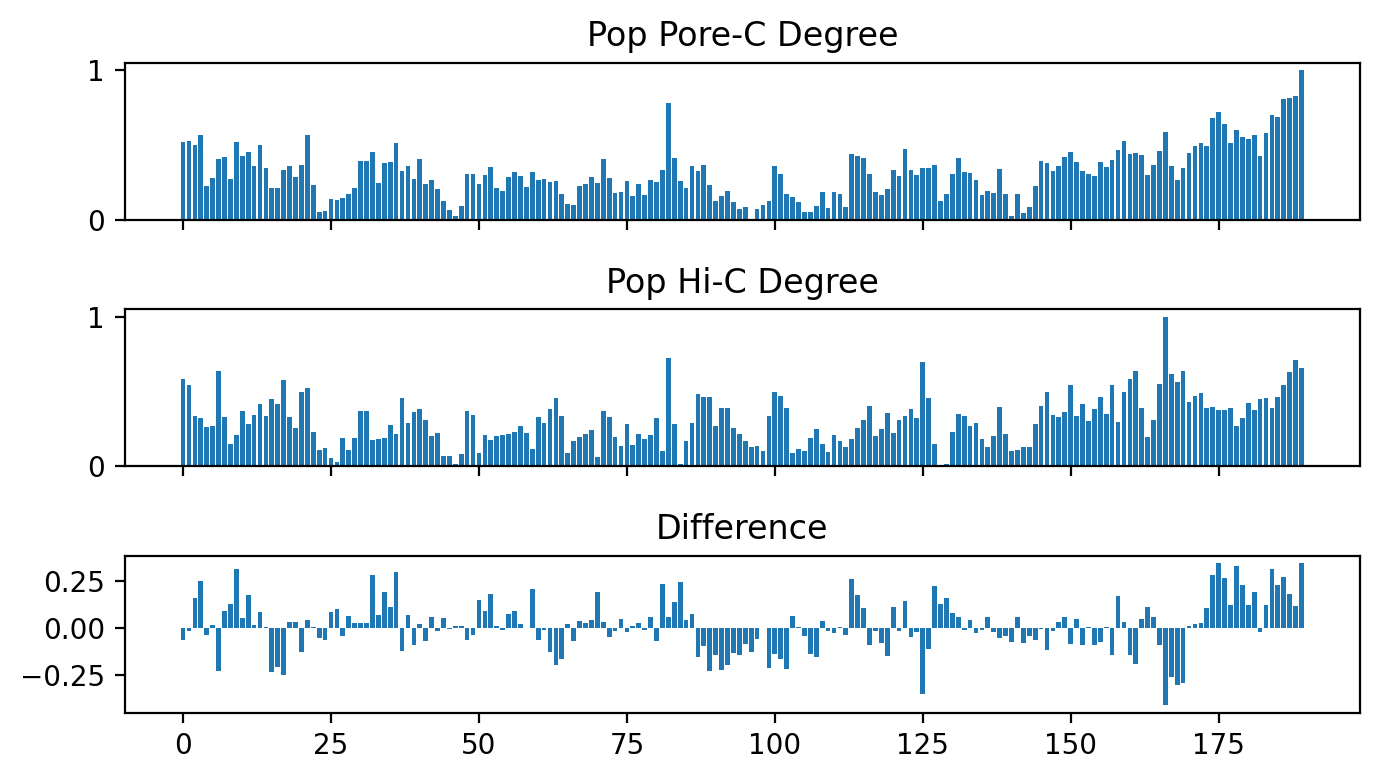

In [55]:
# row sums
deg_pc = np.array(Apc_norm.sum(axis=1)).ravel()
deg_hic = np.array(Ahic_norm.sum(axis=1)).ravel()

n = deg_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].bar(range(n), ut.normalize_1d_array(deg_pc))
axs[1].bar(range(n), ut.normalize_1d_array(deg_hic))
axs[2].bar(range(n), ut.normalize_1d_array(deg_pc) - ut.normalize_1d_array(deg_hic))

axs[0].set_title('Pop Pore-C Degree')
axs[1].set_title('Pop Hi-C Degree')
axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(deg_pc, deg_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

Text(0.5, 0, 'Chrom 1 Loci (1Mb)')

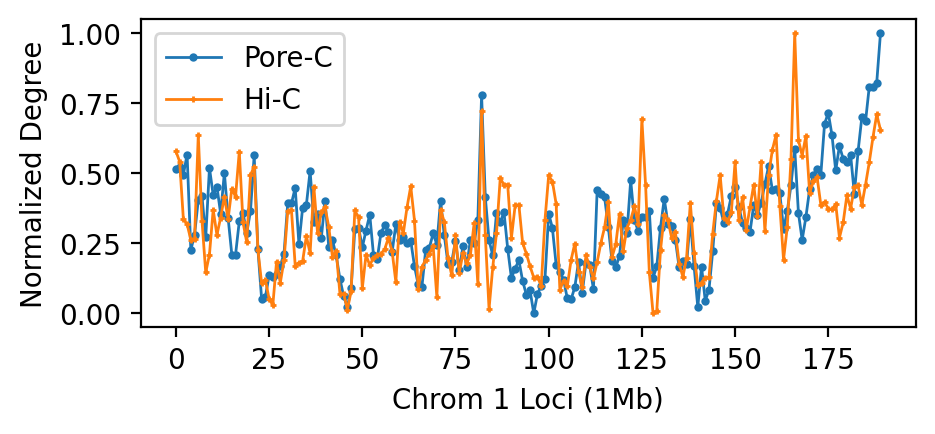

In [56]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

plt.plot(ut.normalize_1d_array(deg_pc), marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(deg_hic), marker="+", markersize=2, lw=1, label='Hi-C')
plt.legend()

plt.ylabel('Normalized Degree')
plt.xlabel('Chrom 1 Loci (1Mb)')

r=0.443 p=0.00000


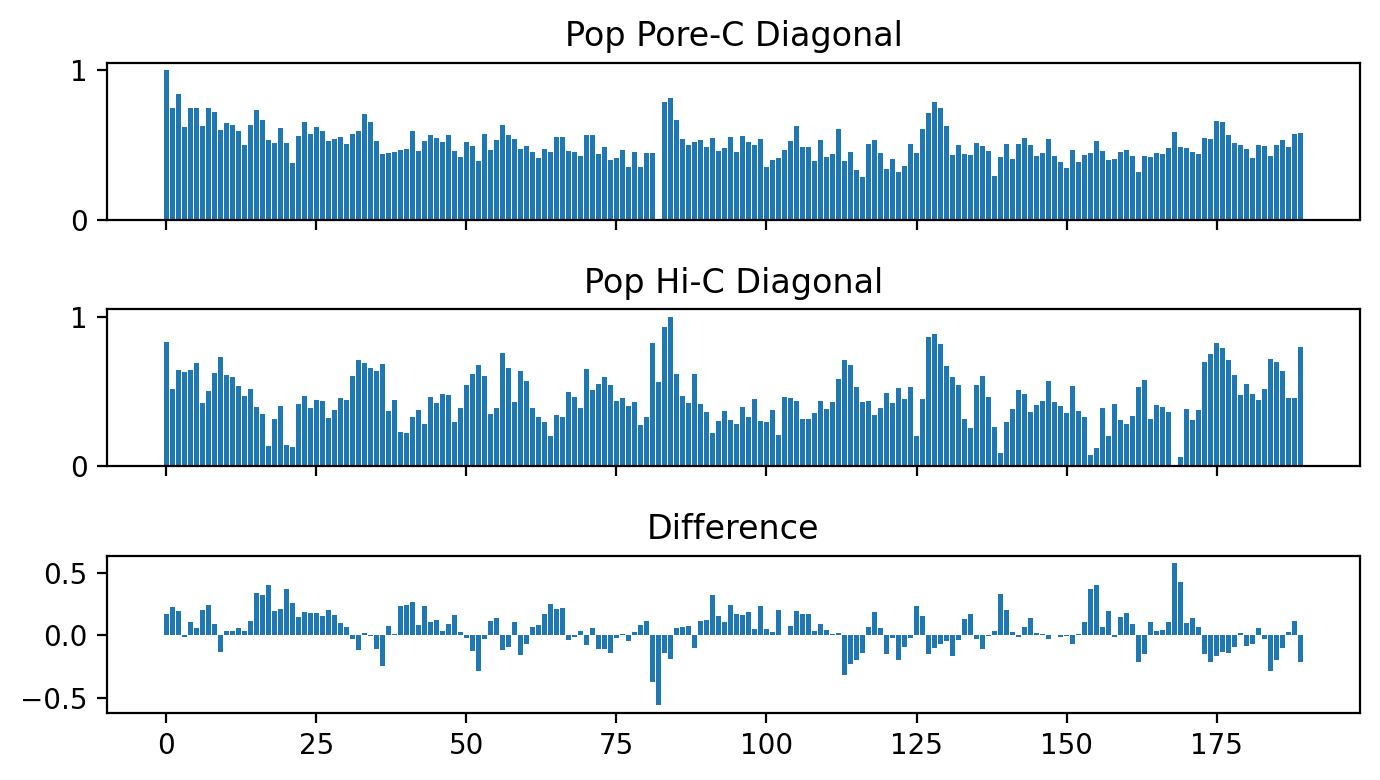

In [57]:
# diagonal
diag_pc = np.diag(Apc_norm)
diag_hic = np.diag(Ahic_norm)

n = diag_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].bar(range(n), ut.normalize_1d_array(diag_pc))
axs[1].bar(range(n), ut.normalize_1d_array(diag_hic))
axs[2].bar(range(n), ut.normalize_1d_array(diag_pc) - ut.normalize_1d_array(diag_hic))

axs[0].set_title('Pop Pore-C Diagonal')
axs[1].set_title('Pop Hi-C Diagonal')
axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(diag_pc, diag_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

Text(0.5, 0, 'Chrom 1 Loci (1Mb)')

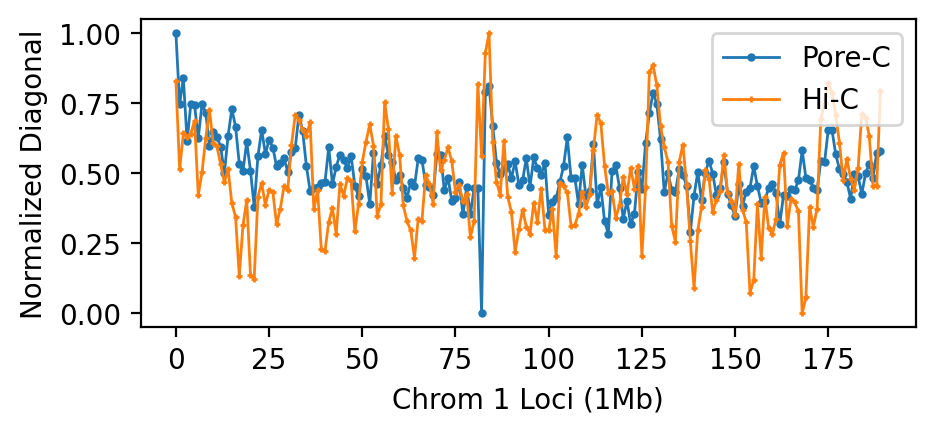

In [58]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 2

plt.plot(ut.normalize_1d_array(diag_pc), marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(diag_hic), marker="+", markersize=2, lw=1, label='Hi-C')
plt.legend()

plt.ylabel('Normalized Diagonal')
plt.xlabel('Chrom 1 Loci (1Mb)')

# principle eigenvectors

Text(0.5, 0, 'Eigenvalue Index')

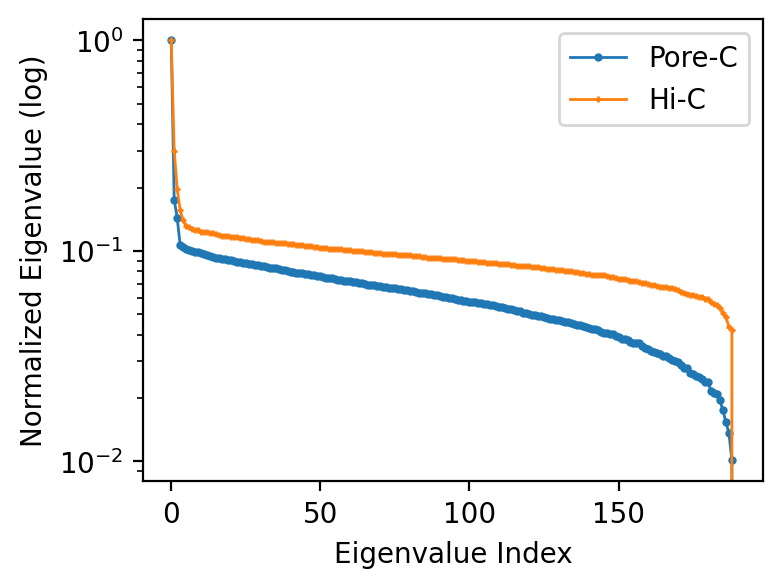

In [59]:
vpc, wpc = np.linalg.eigh(Apc_norm)
vhic, whic = np.linalg.eigh(Ahic_norm)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3
plt.plot(ut.normalize_1d_array(vpc[::-1]),  marker="o", markersize=2, lw=1, label='Pore-C')
plt.plot(ut.normalize_1d_array(vhic[::-1]), marker="+", markersize=2, lw=1, label='Hi-C')

plt.yscale('log')
plt.legend()

plt.ylabel('Normalized Eigenvalue (log)')
plt.xlabel('Eigenvalue Index')

r=0.676 p=0.00000


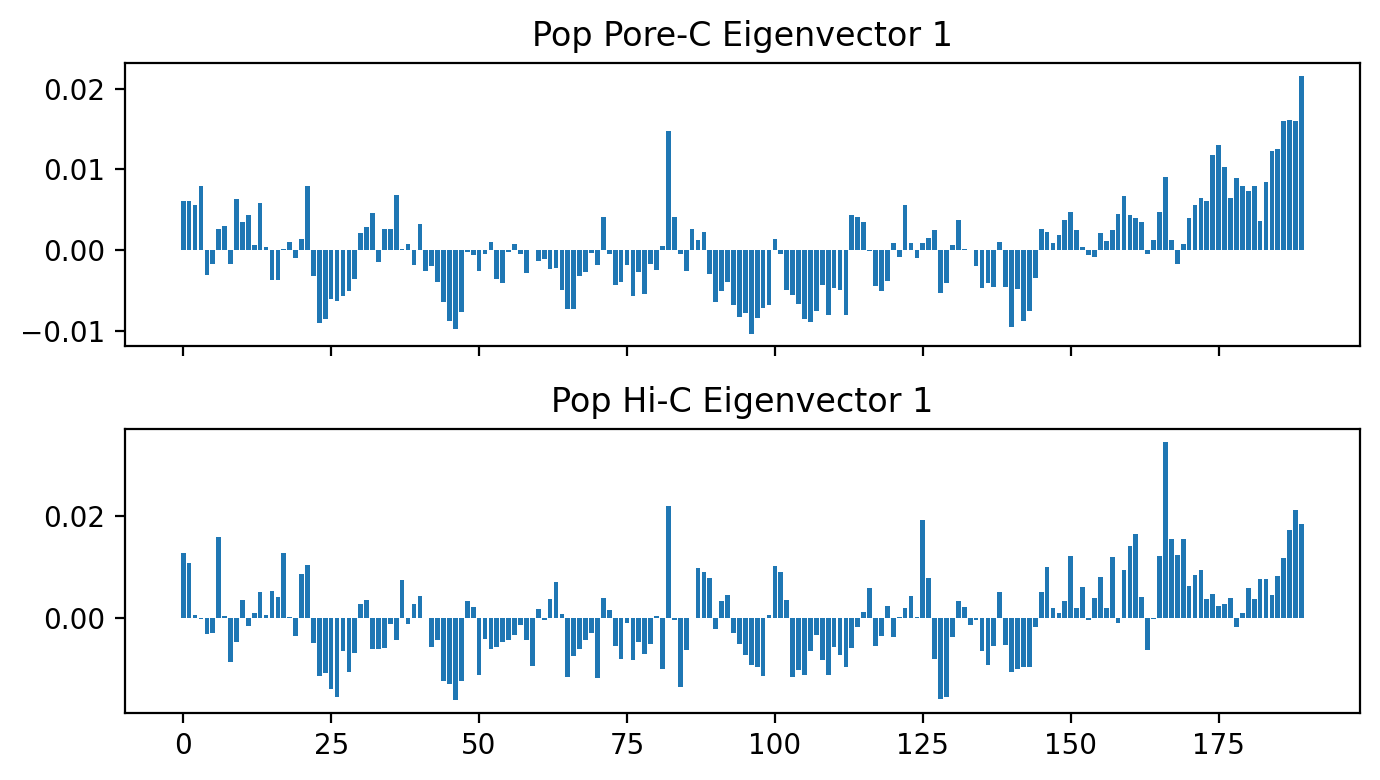

In [60]:
ab_pc = np.array(wpc[:, -1]).ravel()
ab_hic = np.array(whic[:, -1]).ravel()

ab_pc = ab_pc - ab_pc.mean()
ab_hic = ab_hic - ab_hic.mean()

n = ab_pc.shape[0]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 4
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].bar(range(n), ab_pc)
axs[1].bar(range(n), ab_hic)
# axs[2].bar(range(n), ab_pc - ab_hic)

axs[0].set_title('Pop Pore-C Eigenvector 1')
axs[1].set_title('Pop Hi-C Eigenvector 1')
# axs[2].set_title('Difference')

r, p = scipy.stats.pearsonr(ab_pc, ab_hic)
print(f"{r=:.3f} {p=:.5f}")

plt.tight_layout()

Text(0.5, 0, 'Contact Distance (Mb)')

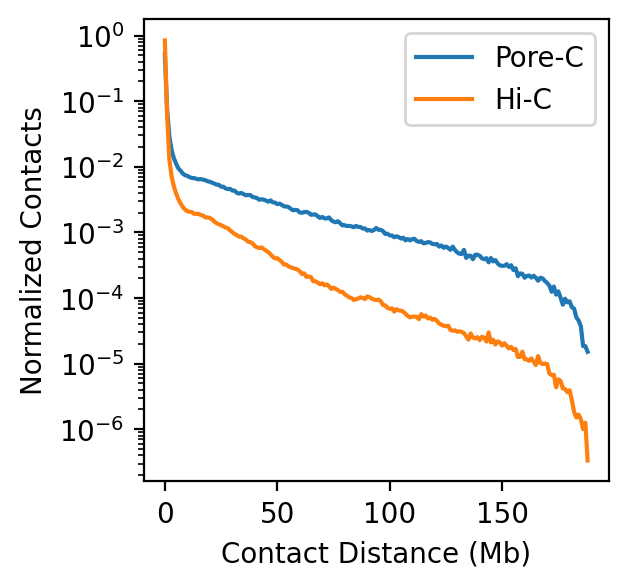

In [61]:
def sum_k_diagonals(matrix):
    """Calculates the sum of all k diagonals in a symmetric matrix.

    Args:
        matrix (np.ndarray): The input symmetric matrix.

    Returns:
        list: A list of sums, where each element represents the sum of a diagonal.
    """

    if not np.allclose(matrix, matrix.T):
        raise ValueError("Input matrix must be symmetric.")

    n = matrix.shape[0]
    result = []

    # Extract elements along each diagonal
    for i in range(n-1):
        diagonal = np.diag(matrix, k=i)
        row = {
            'distance' : i,
            'contacts' : np.sum(diagonal),
        }
        result.append(row)

    return pd.DataFrame(result)
        
        
res_pc = sum_k_diagonals(Apc)
res_hic = sum_k_diagonals(Ahic)

res_pc['normalized_contacts'] = res_pc['contacts'] / res_pc['contacts'].sum()
res_hic['normalized_contacts'] = res_hic['contacts'] / res_hic['contacts'].sum()

plt.rcParams['figure.dpi'] = 200

plt.rcParams['figure.figsize'] = 3, 3
plt.plot(res_pc['distance'],
         res_pc['normalized_contacts'], label='Pore-C')

plt.plot(res_hic['distance'],
         res_hic['normalized_contacts'], label='Hi-C')

plt.yscale('log')
plt.legend()
plt.ylabel('Normalized Contacts')
plt.xlabel('Contact Distance (Mb)')

In [62]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.imshow(I)

In [ ]:
def clique_expand_incidence(I, zero_diag=True):
    """A function to clique expand an incidence matrix """
    node_list = I.index
    A = np.dot(I, I.T)
    if zero_diag:
        A = A - np.diag(np.diag(A))
    A = pd.DataFrame(A, columns=node_list,
                     index=node_list)
    return A
    
A = clique_expand_incidence(I)    
plt.imshow(A)

In [ ]:
A = np.dot(I, I.T)
A = A - np.diag(np.diag(A))
plt.imshow(A)

np.diag(A)

In [ ]:
def explicit_clique_expand(I):
    """A function to perform explicit clique-expansion 
    of an incidence matrix """
    n, h = I.shape
    node_list = I.index
    A = np.zeros((n , n))

    for h in I.columns:
        ind = np.argwhere(I[h] > 0).ravel()
        pairs = list(itertools.combinations(ind, 2))

        for i, j in pairs:
            A[i, j] += 1
            A[j, i] += 1

    return A
    

A_exp = explicit_clique_expand(I)
plt.imshow(A_exp)

In [ ]:
plt.imshow(A_exp - A)

In [ ]:
np.diag(A)

In [ ]:
np.diag(A_exp)

In [ ]:
break